In [ ]:
import numpy as np
import pandas as pd

import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
#import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
plt.style.use('seaborn-whitegrid')

font = {
    'family' : 'Helvetica',
    'weight' : 'bold',
    'size'   : 14
}

mpl.rc('font', **font)

<ipython-input-3-8f724e6d2d53>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [ ]:
effect_size = sms.proportion_effectsize(0.13, 0.15)

required_n = sms.NormalIndPower().solve_power(
    effect_size, power = 0.8, alpha = 0.05, ratio = 1
)


In [ ]:
# округление
required_n = ceil(required_n)
required_n

4720

In [ ]:
df = pd.read_csv('ab_data.csv', error_bad_lines=False)

df.head()

<ipython-input-6-a7a84cd2f2b4>:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv('ab_data.csv', error_bad_lines=False)


,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [ ]:
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


In [ ]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [ ]:
users_to_drop = session_counts[session_counts>1].index

df = df[~df['user_id'].isin(users_to_drop)]

In [ ]:
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


In [ ]:
df.shape

(286690, 5)

In [ ]:
control_sample = df[df['group'] == 'control'].sample(n = required_n, random_state= 22)

treatment_sample = df[df['group'] == 'treatment'].sample(n = required_n, random_state= 22)

print(control_sample.shape, treatment_sample.shape)

(4720, 5) (4720, 5)


In [ ]:
ab_test = pd.concat([control_sample, treatment_sample], axis = 0)

ab_test

,user_id,timestamp,group,landing_page,converted
186628,763854,2017-01-21 03:43:17.188315,control,old_page,0
57904,690555,2017-01-18 06:38:13.079449,control,old_page,0
13276,861520,2017-01-06 21:13:40.044766,control,old_page,0
228415,630778,2017-01-05 16:42:36.995204,control,old_page,0
96065,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
46153,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
235886,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
268794,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
190461,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [ ]:
ab_test.reset_index(drop = True, inplace = True)

In [ ]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [ ]:
conversion_rates = ab_test[['group', 'converted']].groupby('group')

In [ ]:
std_p = lambda x: np.std(x, ddof = 0) #Std. deviation of the proportion

s_err_p = lambda x: stats.sem(x, ddof = 0)  # Std. error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, s_err_p])

In [ ]:
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.123,0.329,0.005
treatment,0.126,0.331,0.005


<ipython-input-28-aeb0ede021a3>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.barplot(x = ab_test.group, y = ab_test.converted, ci = False)


Text(0, 0.5, 'Converted (proportion)')

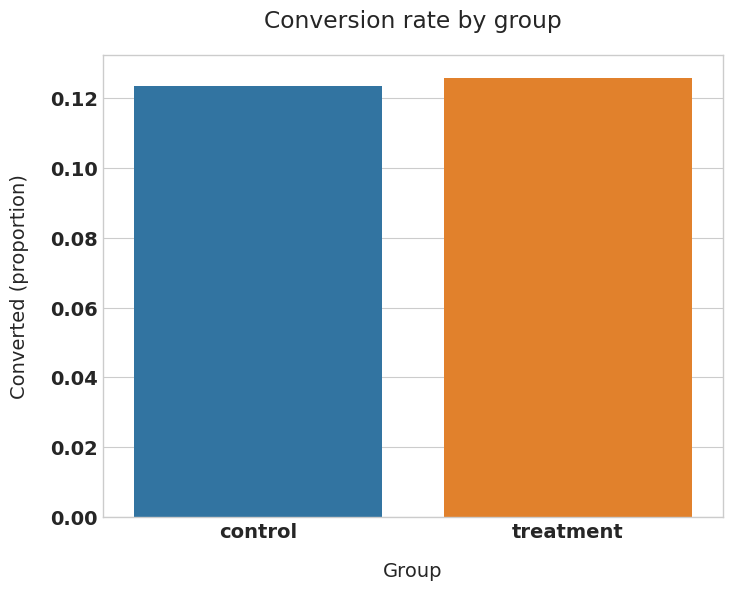

In [ ]:
plt.figure(figsize = (8, 6))

sns.barplot(x = ab_test.group, y = ab_test.converted, ci = False)

plt.ylim = (0, 17)
plt.title('Conversion rate by group', pad = 20)
plt.xlabel('Group', labelpad = 15)
plt.ylabel('Converted (proportion)', labelpad=15)

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [ ]:
control_results = ab_test[ab_test['group'] == 'control']['converted']
tratment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = tratment_results.count()

success = [control_results.sum(), tratment_results.sum()]
nobs = [n_con, n_treat]

z_stat, pval = proportions_ztest(success, nobs = nobs)

(lower_con, lower_treat), (upper_con, upper_treat ) = proportion_confint(success, nobs = nobs, alpha = 0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]
